# Import Libraries

In [19]:
import numpy as np
import pandas as pd
import re
from collections import defaultdict
from itertools import chain
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE

from scipy.spatial.distance import cosine

import seaborn as sns

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


# Normalisation and pre-processing

In [21]:
file_path_train = 'data/train.csv'
file_path_test = 'data/test.csv'
df_train = pd.read_csv(file_path_train, header=None)
df_test = pd.read_csv(file_path_test, header=None)

In [22]:
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours',
    'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
    'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself',
    'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
    'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
    'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
    'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
    "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
])

In [23]:
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

def remove_punctuation_and_numbers(tokens):
    filtered_tokens = [word for word in tokens if word.isalpha()]
    return filtered_tokens

all_tokens = []
for entry in df_train[2]:
    tokens = tokenize(entry)
    tokens = remove_stopwords(tokens)
    tokens = remove_punctuation_and_numbers(tokens)
    all_tokens.extend(tokens)

In [24]:
def generate_skipgram_data(tokens, window_size=2):
    pairs = []
    for i, center_word in enumerate(tokens):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:
                context_word = tokens[j]
                pairs.append((word_to_idx[center_word], word_to_idx[context_word]))
    return pairs

vocab = sorted(set(all_tokens))
vocab_size = len(vocab)

word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}

pairs = generate_skipgram_data(all_tokens, window_size=5)

In [25]:
print(len(all_tokens))

2431560


In [26]:
print(len(vocab))

57645


# Word Embedding Training

In [10]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim) # V matrix with all centre word embeddings
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim) # U matrix with all context word embeddings

    def forward(self, center_word):
        center_embeds = self.center_embeddings(center_word) # Retrieves v_c from V, Shape: [batch_size, embedding_dim]
        context_embeds = self.context_embeddings.weight # Retieves U, Shape: [vocab_size, embedding_dim]
        logits = torch.matmul(center_embeds, context_embeds.t()) # Computes U^T v_c, Result: [batch_size, vocab_size]
        return logits

embedding_dim = 100
model = SkipGramModel(vocab_size, embedding_dim).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [11]:
def prepare_data(pairs):
    X = torch.tensor([pair[0] for pair in pairs], dtype=torch.long) # X = [c_1, ..., c_m] centre words in pairs (m = number of pairs)
    y = torch.tensor([pair[1] for pair in pairs], dtype=torch.long) # y = [o_1, ..., o_m] contex words in pairs
    return X, y

X, y = prepare_data(pairs)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=10000, shuffle=True, pin_memory=True)

epochs = 10
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
average_loss = []

for epoch in range(epochs):
    total_loss = 0
    num_batches = len(dataloader)
    print_interval = max(1, num_batches // 10)
    for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(batch_X)
            loss = loss_function(output, batch_y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        if batch_idx % print_interval == 0:
          print(f'Epoch: {epoch+1}, Batch: {batch_idx+1} out of {num_batches}, Loss: {loss.item()}')

    print(f'Epoch: {epoch+1}, Average Loss: {total_loss/num_batches}')
    average_loss.append(total_loss/num_batches)

center_embeddings = model.center_embeddings.weight.data.cpu().numpy()  # V
context_embeddings = model.context_embeddings.weight.data.cpu().numpy()  # U

Epoch: 1, Batch: 1 out of 2432, Loss: 42.909305572509766
Epoch: 1, Batch: 244 out of 2432, Loss: 13.374306678771973
Epoch: 1, Batch: 487 out of 2432, Loss: 9.750633239746094
Epoch: 1, Batch: 730 out of 2432, Loss: 8.8340482711792
Epoch: 1, Batch: 973 out of 2432, Loss: 8.489203453063965
Epoch: 1, Batch: 1216 out of 2432, Loss: 8.381463050842285
Epoch: 1, Batch: 1459 out of 2432, Loss: 8.292580604553223
Epoch: 1, Batch: 1702 out of 2432, Loss: 8.221327781677246
Epoch: 1, Batch: 1945 out of 2432, Loss: 8.178196907043457
Epoch: 1, Batch: 2188 out of 2432, Loss: 8.113828659057617
Epoch: 1, Batch: 2431 out of 2432, Loss: 8.09564208984375
Epoch: 1, Average Loss: 10.007565239934545
Epoch: 2, Batch: 1 out of 2432, Loss: 7.918172836303711
Epoch: 2, Batch: 244 out of 2432, Loss: 8.003485679626465
Epoch: 2, Batch: 487 out of 2432, Loss: 7.99294900894165
Epoch: 2, Batch: 730 out of 2432, Loss: 8.02148151397705
Epoch: 2, Batch: 973 out of 2432, Loss: 8.045101165771484
Epoch: 2, Batch: 1216 out of 2

In [20]:
np.save('center_embeddings_100.npy', center_embeddings)
np.save('context_embeddings_100.npy', context_embeddings)

# Visualisation

## Epoch = 10, dimension = 100

## 2D Plot

In [35]:
center_embeddings_100 = np.load('center_embeddings_100.npy')

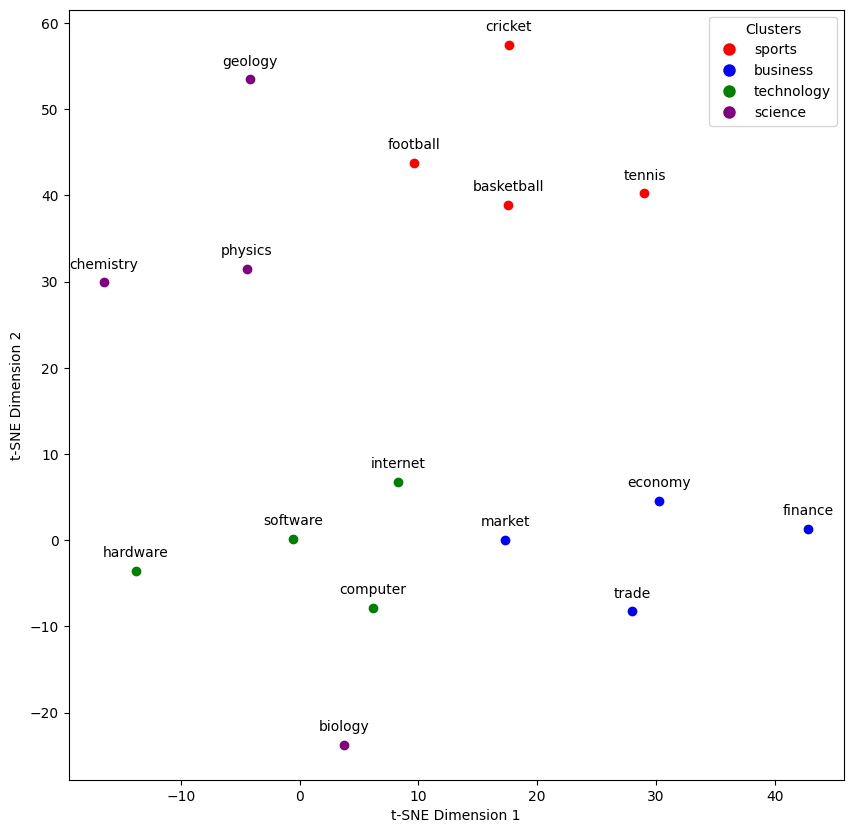

In [36]:
clusters = {
    'sports': ['football', 'basketball', 'tennis', 'cricket'],
    'business': ['market', 'finance', 'economy', 'trade'],
    'technology': ['computer', 'internet', 'software', 'hardware'],
    'science': ['physics', 'chemistry', 'biology', 'geology']
}

selected_words = list(chain.from_iterable(clusters.values()))
selected_indices = [word_to_idx[word] for word in selected_words]
selected_embeddings = center_embeddings_100[selected_indices]

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

def plot_clusters(embeddings, labels, clusters):
    plt.figure(figsize=(10, 10))
    cluster_colors = {
        'sports': 'red',
        'business': 'blue',
        'technology': 'green',
        'science': 'purple'
    }
    legend_handles = []
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        cluster = next(cluster for cluster, words in clusters.items() if label in words)
        plt.scatter(x, y, color=cluster_colors[cluster], label=cluster if cluster not in legend_handles else "")
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
        if cluster not in legend_handles:
            legend_handles.append(cluster)

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[cluster], markersize=10, label=cluster) for cluster in clusters.keys()]
    plt.legend(handles=handles, title="Clusters", loc="upper right")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

plot_clusters(embeddings_2d, selected_words, clusters)

## Confusion matrix with cosine distance

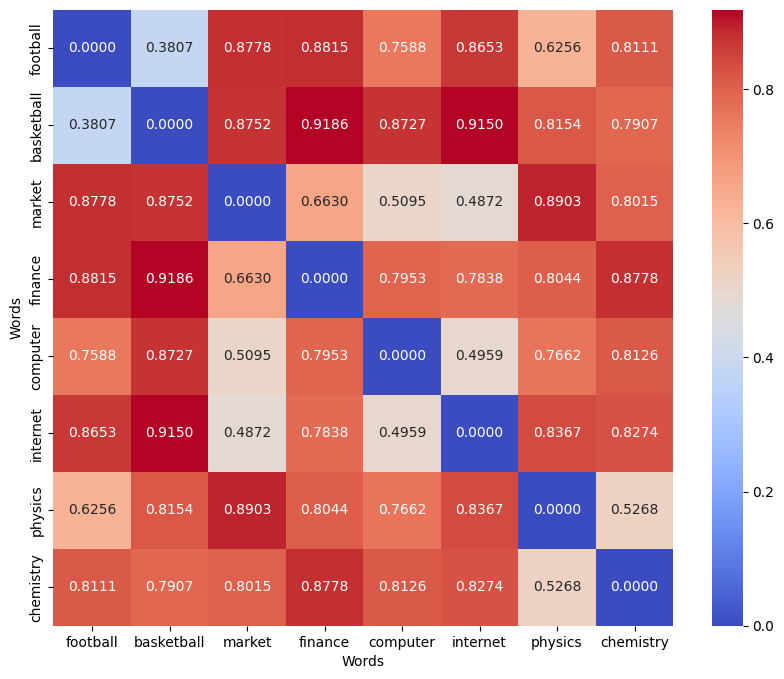

In [29]:
clusters = {
    'sports': ['football', 'basketball'],
    'business': ['market', 'finance'],
    'technology': ['computer', 'internet'],
    'science': ['physics', 'chemistry']
}

selected_words = list(chain.from_iterable(clusters.values()))
selected_indices = [word_to_idx[word] for word in selected_words]
selected_embeddings = center_embeddings_100[selected_indices]

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

def plot_confusion_matrix(embeddings, words):
    distances = np.zeros((len(words), len(words)))
    for i in range(len(words)):
        for j in range(len(words)):
            distances[i, j] = cosine(embeddings[i], embeddings[j])

    dist_df = pd.DataFrame(distances, index=words, columns=words)
    plt.figure(figsize=(10, 8))
    sns.heatmap(dist_df, annot=True, cmap="coolwarm", cbar=True, fmt=".4f")
    plt.xlabel("Words")
    plt.ylabel("Words")
    plt.show()

plot_confusion_matrix(selected_embeddings, selected_words)

## Print Distance

In [30]:
def print_distances(embeddings, words):
    print("Distances between relevant words:\n")
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if i < j:
                dist = cosine(embeddings[i], embeddings[j])
                print(f"Distance between '{word1}' and '{word2}': {dist:.4f}")

print_distances(selected_embeddings, selected_words)

Distances between relevant words:

Distance between 'football' and 'basketball': 0.3807
Distance between 'football' and 'market': 0.8778
Distance between 'football' and 'finance': 0.8815
Distance between 'football' and 'computer': 0.7588
Distance between 'football' and 'internet': 0.8653
Distance between 'football' and 'physics': 0.6256
Distance between 'football' and 'chemistry': 0.8111
Distance between 'basketball' and 'market': 0.8752
Distance between 'basketball' and 'finance': 0.9186
Distance between 'basketball' and 'computer': 0.8727
Distance between 'basketball' and 'internet': 0.9150
Distance between 'basketball' and 'physics': 0.8154
Distance between 'basketball' and 'chemistry': 0.7907
Distance between 'market' and 'finance': 0.6630
Distance between 'market' and 'computer': 0.5095
Distance between 'market' and 'internet': 0.4872
Distance between 'market' and 'physics': 0.8903
Distance between 'market' and 'chemistry': 0.8015
Distance between 'finance' and 'computer': 0.7953


## Epoch = 5, dimension = 10

## 2D Plot

In [31]:
center_embeddings_10 = np.load('center_embeddings_10.npy')

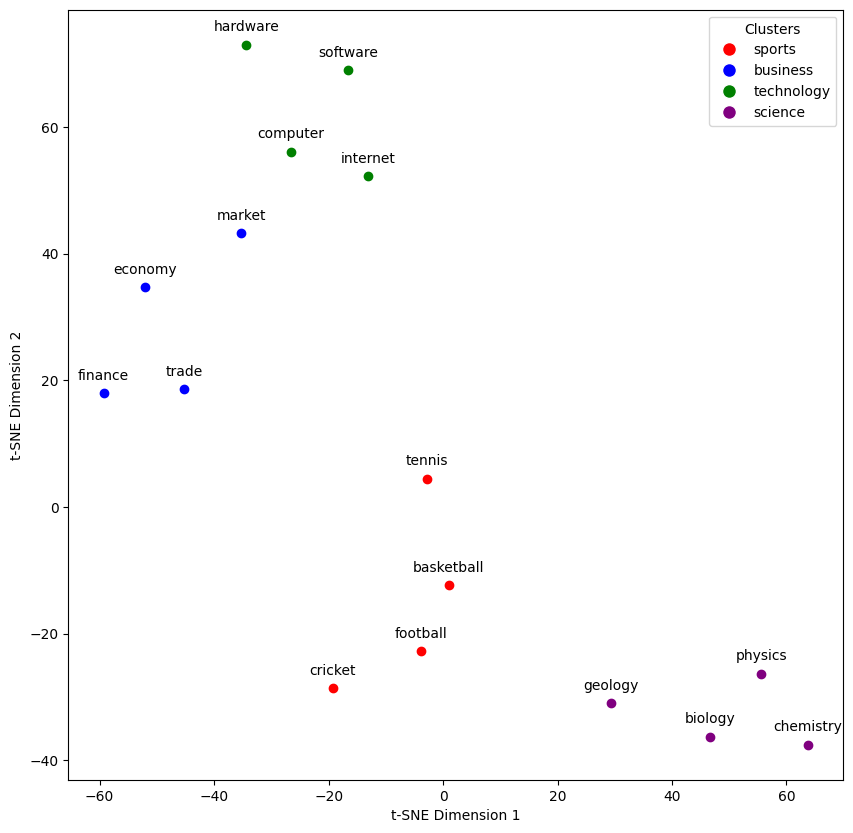

In [32]:
clusters = {
    'sports': ['football', 'basketball', 'tennis', 'cricket'],
    'business': ['market', 'finance', 'economy', 'trade'],
    'technology': ['computer', 'internet', 'software', 'hardware'],
    'science': ['physics', 'chemistry', 'biology', 'geology']
}

selected_words = list(chain.from_iterable(clusters.values()))
selected_indices = [word_to_idx[word] for word in selected_words]
selected_embeddings = center_embeddings_10[selected_indices]

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

def plot_clusters(embeddings, labels, clusters):
    plt.figure(figsize=(10, 10))
    cluster_colors = {
        'sports': 'red',
        'business': 'blue',
        'technology': 'green',
        'science': 'purple'
    }
    legend_handles = []
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        cluster = next(cluster for cluster, words in clusters.items() if label in words)
        plt.scatter(x, y, color=cluster_colors[cluster], label=cluster if cluster not in legend_handles else "")
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
        if cluster not in legend_handles:
            legend_handles.append(cluster)

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[cluster], markersize=10, label=cluster) for cluster in clusters.keys()]
    plt.legend(handles=handles, title="Clusters", loc="upper right")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

plot_clusters(embeddings_2d, selected_words, clusters)

## Confusion matrix with cosine distance

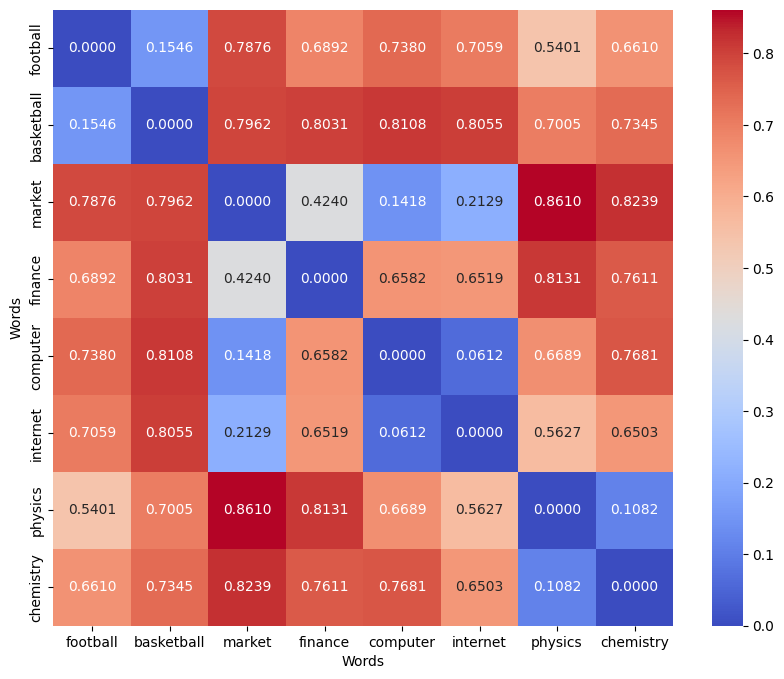

In [33]:
clusters = {
    'sports': ['football', 'basketball'],
    'business': ['market', 'finance'],
    'technology': ['computer', 'internet'],
    'science': ['physics', 'chemistry']
}

selected_words = list(chain.from_iterable(clusters.values()))
selected_indices = [word_to_idx[word] for word in selected_words]
selected_embeddings = center_embeddings_10[selected_indices]

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

def plot_confusion_matrix(embeddings, words):
    distances = np.zeros((len(words), len(words)))
    for i in range(len(words)):
        for j in range(len(words)):
            distances[i, j] = cosine(embeddings[i], embeddings[j])

    dist_df = pd.DataFrame(distances, index=words, columns=words)
    plt.figure(figsize=(10, 8))
    sns.heatmap(dist_df, annot=True, cmap="coolwarm", cbar=True, fmt=".4f")
    plt.xlabel("Words")
    plt.ylabel("Words")
    plt.show()

plot_confusion_matrix(selected_embeddings, selected_words)

## Print Distance

In [34]:
def print_distances(embeddings, words):
    print("Distances between relevant words:\n")
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if i < j:
                dist = cosine(embeddings[i], embeddings[j])
                print(f"Distance between '{word1}' and '{word2}': {dist:.4f}")

print_distances(selected_embeddings, selected_words)

Distances between relevant words:

Distance between 'football' and 'basketball': 0.1546
Distance between 'football' and 'market': 0.7876
Distance between 'football' and 'finance': 0.6892
Distance between 'football' and 'computer': 0.7380
Distance between 'football' and 'internet': 0.7059
Distance between 'football' and 'physics': 0.5401
Distance between 'football' and 'chemistry': 0.6610
Distance between 'basketball' and 'market': 0.7962
Distance between 'basketball' and 'finance': 0.8031
Distance between 'basketball' and 'computer': 0.8108
Distance between 'basketball' and 'internet': 0.8055
Distance between 'basketball' and 'physics': 0.7005
Distance between 'basketball' and 'chemistry': 0.7345
Distance between 'market' and 'finance': 0.4240
Distance between 'market' and 'computer': 0.1418
Distance between 'market' and 'internet': 0.2129
Distance between 'market' and 'physics': 0.8610
Distance between 'market' and 'chemistry': 0.8239
Distance between 'finance' and 'computer': 0.6582


# Classification

## Accuracy

In [29]:
center_embeddings_100 = np.load('center_embeddings_100.npy')

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(df_train[0])
test_labels = label_encoder.transform(df_test[0])

def get_sentence_embedding(sentence, word_to_idx, embeddings):
    tokens = tokenize(sentence)
    tokens = remove_stopwords(tokens)
    tokens = remove_punctuation_and_numbers(tokens)
    valid_tokens = [token for token in tokens if token in word_to_idx]

    if not valid_tokens:
        return np.zeros(embeddings.shape[1])
    indices = [word_to_idx[token] for token in valid_tokens]

    return np.mean(embeddings[indices], axis=0)

train_embeddings = np.array([get_sentence_embedding(sentence, word_to_idx, center_embeddings_100) for sentence in df_train[2]])
test_embeddings = np.array([get_sentence_embedding(sentence, word_to_idx, center_embeddings_100) for sentence in df_test[2]])

classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_embeddings, train_labels)

train_predictions = classifier.predict(train_embeddings)
test_predictions = classifier.predict(test_embeddings)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.8865
Test Accuracy: 0.8782894736842105


## Confusion Matrix for different classes

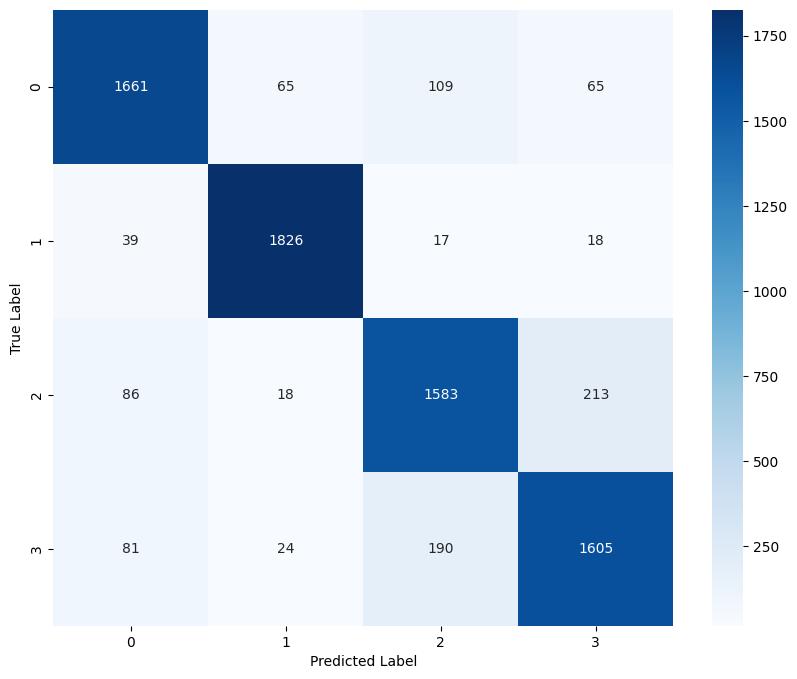

In [31]:
conf_matrix = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_1.pdf')
plt.show()